In [6]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix



In [7]:
# Use pathlib to define file paths
base_dir = Path("d:/GitHub/IFT6390BKaggle2")  # Set your project base directory
train_file_path = base_dir / "Data" / "train_data.pkl"
test_file_path = base_dir / "Data" / "test_data.pkl"

In [8]:
# Load the pickle file
with open(train_file_path, 'rb') as f:
    train_data = pickle.load(f)


X_data = np.array(train_data['images'])  # Convert to NumPy array
y_data = np.array(train_data['labels'])  # Convert to NumPy array

with open(test_file_path, 'rb') as g:
    test_data = pickle.load(g)

# Access images and labels
X_test_data = np.array(test_data['images'])  # Convert to NumPy array


In [9]:
# Print basic information
print("Shape of images:", X_data.shape)  # Expected: (N, 28, 28)
print("Number of labels:", len(y_data))  # Expected: N
print("Unique labels:", np.unique(y_data))

print(X_test_data.shape)


Shape of images: (97477, 28, 28)
Number of labels: 97477
Unique labels: [0 1 2 3]
(1000, 28, 28)


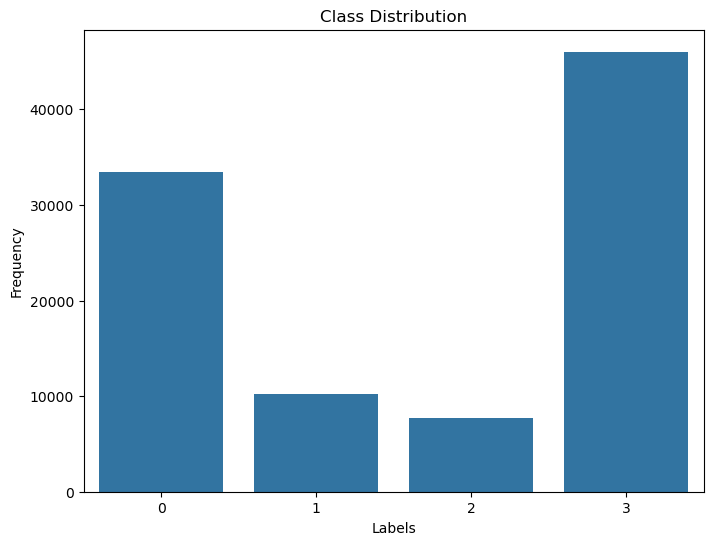

In [40]:
def plot_class_distribution(labels):
    """
    Plot the distribution of labels.
    """
    plt.figure(figsize=(8, 6))
    sns.countplot(x=labels)
    plt.title("Class Distribution")
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.show()

# Plot class distribution
plot_class_distribution(y_data)

In [10]:
def unflatten_images(flattened_images, original_shape):
    """
    Reshape flattened images back to their original shape.

    Parameters:
        flattened_images (ndarray): Flattened image data (num_samples x num_features).
        original_shape (tuple): Original image shape (e.g., height, width, channels).

    Returns:
        ndarray: Reshaped images (num_samples x original_shape).
    """
    return flattened_images.reshape((-1, *original_shape))

In [11]:
def undersample_data(X, y):
    # Identify unique classes and their counts
    unique_classes, class_counts = np.unique(y, return_counts=True)
    print(f"Class counts before undersampling: {dict(zip(unique_classes, class_counts))}")
    
    # Find the smallest class size
    min_class_size = np.min(class_counts)
    
    # Initialize lists to store undersampled data
    X_undersampled = []
    y_undersampled = []
    
    # Iterate through each class and undersample
    for cls in unique_classes:
        # Get indices of the current class
        class_indices = np.where(y == cls)[0]
        
        # Randomly select samples equal to the minimum class size
        undersampled_indices = np.random.choice(class_indices, size=min_class_size, replace=False)
        
        # Append the undersampled data
        X_undersampled.append(X[undersampled_indices])
        y_undersampled.append(y[undersampled_indices])
    
    # Combine all undersampled data
    X_undersampled = np.vstack(X_undersampled)
    y_undersampled = np.concatenate(y_undersampled)
    
    # Shuffle the undersampled data
    shuffled_indices = np.random.permutation(len(y_undersampled))
    X_undersampled = X_undersampled[shuffled_indices]
    y_undersampled = y_undersampled[shuffled_indices]
    
    print(f"Class counts after undersampling: {np.unique(y_undersampled, return_counts=True)}")
    
    return X_undersampled, y_undersampled


In [12]:
def flatten_images(X_train):

    # Get the number of samples in each dataset
    N_train = X_train.shape[0]
    
    # Flatten the images while preserving the batch dimension
    X_train_flat = X_train.reshape(N_train, -1)

    
    return X_train_flat


In [13]:
def train_val_split(X, y, val_ratio=0.2, random_seed=None):

    if random_seed is not None:
        np.random.seed(random_seed)
    
    data_size = X.shape[0]

    # Generate a permutation of indices
    indices = np.random.permutation(data_size)

    # Compute the split point
    split_point = int((1 - val_ratio) * data_size)

    # Split indices for training and validation
    train_indices = indices[:split_point]
    val_indices = indices[split_point:]

    # Use indices to split the data
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_val = X[val_indices]
    y_val = y[val_indices]

    return X_train, y_train, X_val, y_val

In [20]:
X_train_split, y_train_split, X_val_split, y_val_split =   train_val_split(flatten_images(X_data), y_data, val_ratio=0.2, random_seed=42)
X_train_undersampled, y_train_undersampled = undersample_data(X_train, y_train)

Class counts before undersampling: {0: 26847, 1: 8148, 2: 6207, 3: 36779}
Class counts after undersampling: (array([0, 1, 2, 3]), array([6207, 6207, 6207, 6207], dtype=int64))


In [21]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(77981, 784) (77981,) (19496, 784) (19496,)


In [22]:
X_test_flatten = flatten_images(X_test_data)

In [23]:
# Analyze class distribution
unique, counts = np.unique(y_train, return_counts=True)
print("Class distribution in training set:", dict(zip(unique, counts)))

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weights)

Class distribution in training set: {0: 26847, 1: 8148, 2: 6207, 3: 36779}
Class weights: {0: 0.7261612098186017, 1: 2.3926423662248406, 2: 3.1408490414048655, 3: 0.5300647108404253}


In [28]:
# Assuming the original shape of each image is (28, 28)
original_shape = (28, 28)

X_train, y_train = unflatten_images(X_train_undersampled,original_shape), y_train_undersampled

X_val ,y_val = unflatten_images(X_val_split,original_shape),y_val_split

In [30]:
print(X_train.shape,X_val.shape)

(24828, 28, 28) (19496, 28, 28)


# Convolutional Neural Network

In [34]:
# Reshape the data to include the channel dimension
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)


# Check the shape
print(f"x_train shape: {X_train.shape}")
print(f"x_val shape: {X_val.shape}")



x_train shape: (24828, 28, 28, 1)
x_val shape: (19496, 28, 28, 1)


In [35]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(X_train)

# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=20,
    class_weight=class_weights,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

# Evaluate the model on the validation set
y_pred = np.argmax(model.predict(X_val), axis=1)
print(classification_report(y_val, y_pred, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3']))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Epoch 1/20
388/388 [==============================] - 11s 28ms/step - loss: 1.9477 - accuracy: 0.2782 - val_loss: 1.8655 - val_accuracy: 0.1283
Epoch 2/20
388/388 [==============================] - 10s 26ms/step - loss: 1.6098 - accuracy: 0.4068 - val_loss: 1.5468 - val_accuracy: 0.1732
Epoch 3/20
388/388 [==============================] - 10s 26ms/step - loss: 1.4712 - accuracy: 0.4632 - val_loss: 1.6365 - val_accuracy: 0.2132
Epoch 4/20
388/388 [==============================] - 10s 26ms/step - loss: 1.4010 - accuracy: 0.4917 - val_loss: 1.5987 - val_accuracy: 0.2254
Epoch 5/20
388/388 [==============================] - 11s 28ms/step - loss: 1.3475 - accuracy: 0.5108 - val_loss: 1.3037 - val_accuracy: 0.3003
Epoch 6/20
388/388 [==============================] - 11s 27ms/step - loss: 1.3238 - accuracy: 0.5231 - val_loss: 1.5060 - val_accuracy: 0.2623
Epoch 7/20
388/388 [==============================] - 11s 28ms/step - loss: 1.2946 - accuracy: 0.5313 - val_loss: 1.5028 - val_accuracy:

# Test Prediciton

In [37]:
# Reshape the data to include the channel dimension
X_test = X_test_data.reshape(-1, 28, 28, 1)



# Check the shape

print(f"X_test shape: {X_val.shape}")



X_test shape: (19496, 28, 28, 1)


32/32 [==============================] - 0s 2ms/step


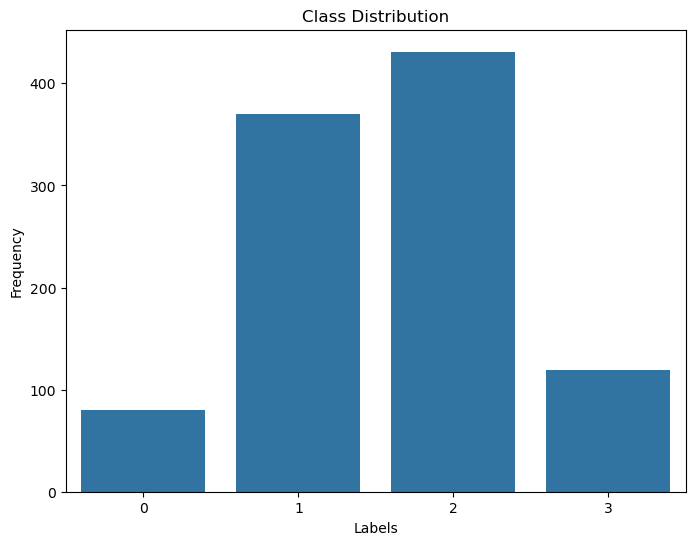

In [41]:
y_test_data = np.argmax(model.predict(X_test), axis=1)
plot_class_distribution(y_test_data)


# Save Predictions

In [43]:
import numpy as np
import pandas as pd
import pickle

# Create a DataFrame for the output


def save_y_csv(y):

    submission_data = pd.DataFrame({
        "ID": np.arange(1, len(y) + 1),  # IDs start from 1
        "Class": y
    })
    # Save to CSV
    output_filename = "submission_milestone_2.csv"
    submission_data.to_csv(output_filename, index=False)
    
    print(f"Submission file saved as {output_filename}")


In [44]:
y = y_test_data
save_y_csv(y)

Submission file saved as submission_milestone_2.csv


In [ ]:
y.shape